In [1]:
from lightgbm import LGBMClassifier

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

from sklearn.model_selection import GridSearchCV
import optuna
from optuna.trial import Trial
from optuna.samplers import TPESampler
import warnings
warnings.filterwarnings('ignore')

In [20]:
# Data Loading
X_model = pd.read_csv('X_model.csv')
Y_model = pd.read_csv('Y_model.csv')
# Define preprocessors
def preprocess(X: pd.DataFrame):
    X = X.fillna(0)
    # Create new dataframe from columns "gender", "age_code", and "region_code"
    X_new = pd.DataFrame(X, columns=['gender', 'age_code', 'region_code'])
    print(X_new)
    GIT_range = r"202205[0-9]{2}"
    cGIT = np.sum(X.filter(regex=("c" + GIT_range), axis=1).values, axis=1)
    tGIT = np.sum(X.filter(regex=("t" + GIT_range), axis=1).values, axis=1)
    sGIT = np.sum(X.filter(regex=("s" + GIT_range), axis=1).values, axis=1)

    VAT_range = r"20220[17](?:[01][0-9]|2[0-5])"
    tVAT = np.sum(X.filter(regex=("t" + VAT_range), axis=1).values, axis=1)
    sVAT = np.sum(X.filter(regex=("s" + VAT_range), axis=1).values, axis=1)

    entire_range = r"2022[0-9]{4}"
    cEntire = np.sum(X.filter(regex=("c" + entire_range), axis=1).values, axis=1)
    tEntire = np.sum(X.filter(regex=("t" + entire_range), axis=1).values, axis=1)
    sEntire = np.sum(X.filter(regex=("s" + entire_range), axis=1).values, axis=1)

    rcGIT = np.divide(cGIT, cEntire)
    rtGIT = np.divide(tGIT, tEntire)
    rsGIT = np.divide(sGIT, sEntire)

    rtVAT = np.divide(tVAT, tEntire)
    rsVAT = np.divide(sVAT, sEntire)

    X_new['cGIT'] = cGIT
    X_new['tGIT'] = tGIT
    X_new['sGIT'] = sGIT

    X_new['tVAT'] = tVAT
    X_new['sVAT'] = sVAT

    X_new['cEntire'] = cEntire
    X_new['tEntire'] = tEntire
    X_new['sEntire'] = sEntire

    X_new['rcGIT'] = rcGIT
    X_new['rtGIT'] = rtGIT
    X_new['rsGIT'] = rsGIT

    X_new['rtVAT'] = rtVAT
    X_new['rsVAT'] = rsVAT

    X_new = X_new.fillna(0)
    print(X_new.head())

    return X_new
# Preprocess
X_model = preprocess(X_model)

        gender  age_code  region_code
0            1        13            7
1            1         5            1
2            2         6            2
3            2         1            1
4            2         5            1
...        ...       ...          ...
799995       1         6           16
799996       2        11           12
799997       1         4            7
799998       1         7            1
799999       2         7            1

[800000 rows x 3 columns]
   gender  age_code  region_code  cGIT  tGIT    sGIT  tVAT    sVAT  cEntire  \
0       1        13            7   0.0   0.0     0.0   0.0     0.0      1.0   
1       1         5            1   2.0   0.0    17.0   0.0   185.0     39.0   
2       2         6            2   6.0   3.0  2253.0   0.0  1712.0     26.0   
3       2         1            1   2.0   0.0   342.0   0.0     0.0      5.0   
4       2         5            1   2.0   0.0   273.0   0.0   104.0     10.0   

   tEntire  sEntire     rcGIT  rtGIT     r

In [3]:
#optimize by using optuna
def optimizeLGBM(trial):
    lgbm = LGBMClassifier(
                          task = "train",
                          objective = "binary",
#                           boosting = "gdbt", #rf
                          n_estimators=100,
                          # to deal with overfitting, very important param
                          max_depth = trial.suggest_int('max_depth',10,20),
                          learning_rate = 0.001,
                          num_leaves = trial.suggest_int('num_leaves',900,1000),
                          min_data_in_leaf = trial.suggest_int('min_data_in_leaf',140,200),
                          metric = "auc",
                          #if max_bin becomes small, the accuracy goes up
                          max_bin = trial.suggest_int('max_bin',255,300),
                          tree_learner = "data",
                          lambda_l1 = trial.suggest_loguniform('lambda_l1', 1e-3, 10.0),
                          lambda_l2 = trial.suggest_loguniform('lambda_l2', 1e-3, 10.0),
                          # to deal with overfitting
                          min_child_weight = trial.suggest_int('min_child_weight', 5, 13),
                          random_state=100,
                          class_weight = "balanced"
#                           min_gain_to_split = ,
#                           bagging_fraction = ,
#                           early_stopping_round = ,
    )

    score = cross_val_score(lgbm, X_model, Y_model, cv=StratifiedKFold(n_splits=4, shuffle=True, random_state=100),
                            scoring="roc_auc")
    return score.mean()

optuna.logging.set_verbosity(optuna.logging.WARNING)
LGBM_study = optuna.create_study(direction='maximize')
LGBM_study.optimize(optimizeLGBM, show_progress_bar=True, n_trials=100)


# Print the best parameters
print(LGBM_study.best_params)

  0%|          | 0/100 [00:00<?, ?it/s]

[LightGBM] [Warning] min_data_in_leaf is set=126, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=126
[LightGBM] [Warning] lambda_l1 is set=0.004117586188417907, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.004117586188417907
[LightGBM] [Warning] lambda_l2 is set=0.060382737534537566, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.060382737534537566
[LightGBM] [Warning] min_data_in_leaf is set=126, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=126
[LightGBM] [Warning] lambda_l1 is set=0.004117586188417907, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.004117586188417907
[LightGBM] [Warning] lambda_l2 is set=0.060382737534537566, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.060382737534537566
[LightGBM] [Warning] min_data_in_leaf is set=126, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=126
[LightGBM] [Warning] lambda_l1 is set=0.004117586188417907, reg_alpha=0.0 will

[LightGBM] [Warning] min_data_in_leaf is set=123, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=123
[LightGBM] [Warning] lambda_l1 is set=0.07939517850111427, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.07939517850111427
[LightGBM] [Warning] lambda_l2 is set=0.0012071620908220208, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0012071620908220208
[LightGBM] [Warning] min_data_in_leaf is set=123, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=123
[LightGBM] [Warning] lambda_l1 is set=0.07939517850111427, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.07939517850111427
[LightGBM] [Warning] lambda_l2 is set=0.0012071620908220208, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0012071620908220208
[LightGBM] [Warning] min_data_in_leaf is set=123, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=123
[LightGBM] [Warning] lambda_l1 is set=0.07939517850111427, reg_alpha=0.0 will 

[LightGBM] [Warning] min_data_in_leaf is set=148, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=148
[LightGBM] [Warning] lambda_l1 is set=2.9577571949247163, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9577571949247163
[LightGBM] [Warning] lambda_l2 is set=2.0510158028439194, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.0510158028439194
[LightGBM] [Warning] min_data_in_leaf is set=148, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=148
[LightGBM] [Warning] lambda_l1 is set=2.9577571949247163, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9577571949247163
[LightGBM] [Warning] lambda_l2 is set=2.0510158028439194, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.0510158028439194
[LightGBM] [Warning] min_data_in_leaf is set=150, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=150
[LightGBM] [Warning] lambda_l1 is set=7.1990102613599944, reg_alpha=0.0 will be ignored. Curre

[LightGBM] [Warning] min_data_in_leaf is set=144, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=144
[LightGBM] [Warning] lambda_l1 is set=2.497149092575323, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.497149092575323
[LightGBM] [Warning] lambda_l2 is set=0.02137571533792698, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02137571533792698
[LightGBM] [Warning] min_data_in_leaf is set=144, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=144
[LightGBM] [Warning] lambda_l1 is set=2.497149092575323, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.497149092575323
[LightGBM] [Warning] lambda_l2 is set=0.02137571533792698, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02137571533792698
[LightGBM] [Warning] min_data_in_leaf is set=144, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=144
[LightGBM] [Warning] lambda_l1 is set=2.497149092575323, reg_alpha=0.0 will be ignored. Curren

[LightGBM] [Warning] min_data_in_leaf is set=113, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=113
[LightGBM] [Warning] lambda_l1 is set=4.146794499675232, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.146794499675232
[LightGBM] [Warning] lambda_l2 is set=0.00436354264853174, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00436354264853174
[LightGBM] [Warning] min_data_in_leaf is set=113, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=113
[LightGBM] [Warning] lambda_l1 is set=4.146794499675232, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.146794499675232
[LightGBM] [Warning] lambda_l2 is set=0.00436354264853174, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00436354264853174
[LightGBM] [Warning] min_data_in_leaf is set=113, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=113
[LightGBM] [Warning] lambda_l1 is set=4.146794499675232, reg_alpha=0.0 will be ignored. Curren

[LightGBM] [Warning] min_data_in_leaf is set=139, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=139
[LightGBM] [Warning] lambda_l1 is set=3.8202005551600413, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.8202005551600413
[LightGBM] [Warning] lambda_l2 is set=0.15081167824625866, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.15081167824625866
[LightGBM] [Warning] min_data_in_leaf is set=139, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=139
[LightGBM] [Warning] lambda_l1 is set=3.8202005551600413, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.8202005551600413
[LightGBM] [Warning] lambda_l2 is set=0.15081167824625866, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.15081167824625866
[LightGBM] [Warning] min_data_in_leaf is set=108, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=108
[LightGBM] [Warning] lambda_l1 is set=1.4301623152529137, reg_alpha=0.0 will be ignored. C

[LightGBM] [Warning] min_data_in_leaf is set=145, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=145
[LightGBM] [Warning] lambda_l1 is set=8.555590237798022, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.555590237798022
[LightGBM] [Warning] lambda_l2 is set=0.09699765877690808, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.09699765877690808
[LightGBM] [Warning] min_data_in_leaf is set=145, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=145
[LightGBM] [Warning] lambda_l1 is set=4.9096225522628325, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.9096225522628325
[LightGBM] [Warning] lambda_l2 is set=0.013296968136661267, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.013296968136661267
[LightGBM] [Warning] min_data_in_leaf is set=145, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=145
[LightGBM] [Warning] lambda_l1 is set=4.9096225522628325, reg_alpha=0.0 will be ignored. C

[LightGBM] [Warning] min_data_in_leaf is set=120, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=120
[LightGBM] [Warning] lambda_l1 is set=8.389676674951934, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.389676674951934
[LightGBM] [Warning] lambda_l2 is set=0.002055479694995801, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.002055479694995801
[LightGBM] [Warning] min_data_in_leaf is set=120, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=120
[LightGBM] [Warning] lambda_l1 is set=8.389676674951934, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.389676674951934
[LightGBM] [Warning] lambda_l2 is set=0.002055479694995801, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.002055479694995801
[LightGBM] [Warning] min_data_in_leaf is set=120, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=120
[LightGBM] [Warning] lambda_l1 is set=8.389676674951934, reg_alpha=0.0 will be ignored. Cu

[LightGBM] [Warning] min_data_in_leaf is set=123, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=123
[LightGBM] [Warning] lambda_l1 is set=9.36752825679086, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.36752825679086
[LightGBM] [Warning] lambda_l2 is set=0.005654489593625079, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.005654489593625079
[LightGBM] [Warning] min_data_in_leaf is set=123, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=123
[LightGBM] [Warning] lambda_l1 is set=9.36752825679086, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.36752825679086
[LightGBM] [Warning] lambda_l2 is set=0.005654489593625079, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.005654489593625079
[LightGBM] [Warning] min_data_in_leaf is set=123, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=123
[LightGBM] [Warning] lambda_l1 is set=9.36752825679086, reg_alpha=0.0 will be ignored. Current

[LightGBM] [Warning] min_data_in_leaf is set=104, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=104
[LightGBM] [Warning] lambda_l1 is set=0.4260585697046467, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4260585697046467
[LightGBM] [Warning] lambda_l2 is set=0.015738154112473618, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.015738154112473618
[LightGBM] [Warning] min_data_in_leaf is set=104, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=104
[LightGBM] [Warning] lambda_l1 is set=0.4260585697046467, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4260585697046467
[LightGBM] [Warning] lambda_l2 is set=0.015738154112473618, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.015738154112473618
[LightGBM] [Warning] min_data_in_leaf is set=148, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=148
[LightGBM] [Warning] lambda_l1 is set=1.200899304690099, reg_alpha=0.0 will be ignored

[LightGBM] [Warning] min_data_in_leaf is set=143, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=143
[LightGBM] [Warning] lambda_l1 is set=3.2987278123739183, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.2987278123739183
[LightGBM] [Warning] lambda_l2 is set=0.0030584025474337407, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0030584025474337407
[LightGBM] [Warning] min_data_in_leaf is set=142, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=142
[LightGBM] [Warning] lambda_l1 is set=3.422284403467765, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.422284403467765
[LightGBM] [Warning] lambda_l2 is set=0.003054829164910115, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.003054829164910115
[LightGBM] [Warning] min_data_in_leaf is set=142, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=142
[LightGBM] [Warning] lambda_l1 is set=3.422284403467765, reg_alpha=0.0 will be ignored

[LightGBM] [Warning] min_data_in_leaf is set=104, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=104
[LightGBM] [Warning] lambda_l1 is set=5.1399688997985296, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.1399688997985296
[LightGBM] [Warning] lambda_l2 is set=0.006704450238179848, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.006704450238179848
[LightGBM] [Warning] min_data_in_leaf is set=104, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=104
[LightGBM] [Warning] lambda_l1 is set=5.1399688997985296, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.1399688997985296
[LightGBM] [Warning] lambda_l2 is set=0.006704450238179848, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.006704450238179848
[LightGBM] [Warning] min_data_in_leaf is set=104, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=104
[LightGBM] [Warning] lambda_l1 is set=5.1399688997985296, reg_alpha=0.0 will be ignore

[LightGBM] [Warning] min_data_in_leaf is set=143, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=143
[LightGBM] [Warning] lambda_l1 is set=6.654883033537598, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.654883033537598
[LightGBM] [Warning] lambda_l2 is set=0.006200882232194584, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.006200882232194584
[LightGBM] [Warning] min_data_in_leaf is set=143, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=143
[LightGBM] [Warning] lambda_l1 is set=6.654883033537598, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.654883033537598
[LightGBM] [Warning] lambda_l2 is set=0.006200882232194584, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.006200882232194584
[LightGBM] [Warning] min_data_in_leaf is set=143, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=143
[LightGBM] [Warning] lambda_l1 is set=6.654883033537598, reg_alpha=0.0 will be ignored. Cu

[LightGBM] [Warning] min_data_in_leaf is set=147, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=147
[LightGBM] [Warning] lambda_l1 is set=4.570127924510339, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.570127924510339
[LightGBM] [Warning] lambda_l2 is set=0.03233309683102213, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.03233309683102213
[LightGBM] [Warning] min_data_in_leaf is set=147, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=147
[LightGBM] [Warning] lambda_l1 is set=4.570127924510339, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.570127924510339
[LightGBM] [Warning] lambda_l2 is set=0.03233309683102213, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.03233309683102213
[LightGBM] [Warning] min_data_in_leaf is set=147, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=147
[LightGBM] [Warning] lambda_l1 is set=4.186840575768272, reg_alpha=0.0 will be ignored. Curren

[LightGBM] [Warning] min_data_in_leaf is set=149, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=149
[LightGBM] [Warning] lambda_l1 is set=4.452149803292445, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.452149803292445
[LightGBM] [Warning] lambda_l2 is set=0.011923843242630227, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.011923843242630227
[LightGBM] [Warning] min_data_in_leaf is set=149, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=149
[LightGBM] [Warning] lambda_l1 is set=4.712871037649183, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.712871037649183
[LightGBM] [Warning] lambda_l2 is set=0.012205956480648032, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.012205956480648032
[LightGBM] [Warning] min_data_in_leaf is set=149, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=149
[LightGBM] [Warning] lambda_l1 is set=4.712871037649183, reg_alpha=0.0 will be ignored. Cu

[LightGBM] [Warning] min_data_in_leaf is set=146, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=146
[LightGBM] [Warning] lambda_l1 is set=7.751231246335506, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.751231246335506
[LightGBM] [Warning] lambda_l2 is set=0.03934478615190812, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.03934478615190812
[LightGBM] [Warning] min_data_in_leaf is set=146, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=146
[LightGBM] [Warning] lambda_l1 is set=7.751231246335506, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.751231246335506
[LightGBM] [Warning] lambda_l2 is set=0.03934478615190812, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.03934478615190812
[LightGBM] [Warning] min_data_in_leaf is set=146, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=146
[LightGBM] [Warning] lambda_l1 is set=7.751231246335506, reg_alpha=0.0 will be ignored. Curren

[LightGBM] [Warning] min_data_in_leaf is set=145, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=145
[LightGBM] [Warning] lambda_l1 is set=0.019154625643478924, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.019154625643478924
[LightGBM] [Warning] lambda_l2 is set=0.27195844652914014, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.27195844652914014
[LightGBM] [Warning] min_data_in_leaf is set=145, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=145
[LightGBM] [Warning] lambda_l1 is set=0.019154625643478924, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.019154625643478924
[LightGBM] [Warning] lambda_l2 is set=0.27195844652914014, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.27195844652914014
[LightGBM] [Warning] min_data_in_leaf is set=145, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=145
[LightGBM] [Warning] lambda_l1 is set=0.019154625643478924, reg_alpha=0.0 will be 

[LightGBM] [Warning] min_data_in_leaf is set=146, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=146
[LightGBM] [Warning] lambda_l1 is set=5.580508376819504, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.580508376819504
[LightGBM] [Warning] lambda_l2 is set=0.08927141334484666, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.08927141334484666
[LightGBM] [Warning] min_data_in_leaf is set=146, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=146
[LightGBM] [Warning] lambda_l1 is set=5.580508376819504, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.580508376819504
[LightGBM] [Warning] lambda_l2 is set=0.08927141334484666, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.08927141334484666
[LightGBM] [Warning] min_data_in_leaf is set=149, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=149
[LightGBM] [Warning] lambda_l1 is set=2.2588885302907484, reg_alpha=0.0 will be ignored. Curre

[LightGBM] [Warning] min_data_in_leaf is set=150, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=150
[LightGBM] [Warning] lambda_l1 is set=4.162164575236527, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.162164575236527
[LightGBM] [Warning] lambda_l2 is set=0.11794125597514038, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.11794125597514038
[LightGBM] [Warning] min_data_in_leaf is set=150, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=150
[LightGBM] [Warning] lambda_l1 is set=5.56654350184151, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.56654350184151
[LightGBM] [Warning] lambda_l2 is set=0.4376891547408949, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.4376891547408949
[LightGBM] [Warning] min_data_in_leaf is set=150, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=150
[LightGBM] [Warning] lambda_l1 is set=5.56654350184151, reg_alpha=0.0 will be ignored. Current val

{'max_depth': 13, 'num_leaves': 927, 'min_data_in_leaf': 146, 'max_bin': 260, 'lambda_l1': 4.309197899278707, 'lambda_l2': 0.05254292954505944, 'min_child_weight': 9.516405110796251}


In [11]:
# apply model and fit
optimized_LGBM = LGBMClassifier(task = "predict",
                          objective = "binary",
#                           boosting = gdbt, #rf
                          n_estimators=100,
                          # to deal with overfitting, very important param
                          max_depth = LGBM_study.best_params['max_depth'],
                          learning_rate = 0.001,
                          num_leaves = LGBM_study.best_params['num_leaves'],
                          min_data_in_leaf = LGBM_study.best_params['min_data_in_leaf'],
                          metric = "auc",
                          #if max_bin becomes small, the accuracy goes up
                          max_bin = LGBM_study.best_params['max_bin'],
                          tree_learner = "data",
                          lambda_l1 = LGBM_study.best_params['lambda_l1'],
                          lambda_l2 = LGBM_study.best_params['lambda_l2'],
                          # to deal with overfitting
                          min_child_weight = 9, #LGBM_study.best_params['min_child_weight']
                          random_state=100,
                          class_weight = "balanced"
#                           min_gain_to_split = ,
#                           bagging_fraction = ,
#                           early_stopping_round = ,
    )

optimized_LGBM.fit(X_model,Y_model)

[LightGBM] [Warning] min_data_in_leaf is set=146, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=146
[LightGBM] [Warning] lambda_l1 is set=4.309197899278707, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.309197899278707
[LightGBM] [Warning] lambda_l2 is set=0.05254292954505944, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.05254292954505944


LGBMClassifier(class_weight='balanced', lambda_l1=4.309197899278707,
               lambda_l2=0.05254292954505944, learning_rate=0.001, max_bin=260,
               max_depth=13, metric='auc', min_child_weight=9,
               min_data_in_leaf=146, num_leaves=927, objective='binary',
               random_state=100, task='predict', tree_learner='data')

[LightGBM] [Warning] min_data_in_leaf is set=146, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=146
[LightGBM] [Warning] lambda_l1 is set=4.309197899278707, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.309197899278707
[LightGBM] [Warning] lambda_l2 is set=0.05254292954505944, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.05254292954505944
[LightGBM] [Warning] min_data_in_leaf is set=146, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=146
[LightGBM] [Warning] lambda_l1 is set=4.309197899278707, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.309197899278707
[LightGBM] [Warning] lambda_l2 is set=0.05254292954505944, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.05254292954505944
[LightGBM] [Warning] min_data_in_leaf is set=146, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=146
[LightGBM] [Warning] lambda_l1 is set=4.309197899278707, reg_alpha=0.0 will be ignored. Curren

<BarContainer object of 5 artists>

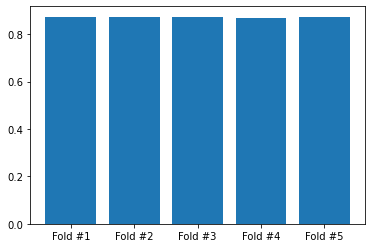

In [12]:
# evaluate
scores = cross_val_score(
    optimized_LGBM, 
    X_model, 
    Y_model, 
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=100),
    scoring='roc_auc'
)
print("Average ROC AUC Score", np.mean(scores))
print("Standard Deviation of ROC AUC Score", np.std(scores))
# Plot 5 scores in bar plot
print(scores)
plt.bar(list(map(lambda i: f"Fold #{i}", range(1, 6))), scores)

In [16]:
X_exam = pd.read_csv('X_exam.csv')
X_exam = preprocess(X_exam)
Y_pred = optimized_LGBM.predict_proba(X_model)[:,1]
roc_auc_score(Y_model, Y_pred)

   gender  age_code  region_code  cGIT  tGIT   sGIT  tVAT    sVAT  cEntire  \
0       2         4            4   4.0   0.0   19.0   2.0   468.0     16.0   
1       2        10           15   0.0   0.0    0.0   0.0     0.0      7.0   
2       2         4            2   4.0   0.0  800.0   2.0  2719.0     48.0   
3       1         8            1   1.0   0.0   50.0   0.0     0.0     13.0   
4       2         8            2   0.0   0.0    0.0   1.0   488.0      1.0   

   tEntire  sEntire     rcGIT  rtGIT     rsGIT     rtVAT     rsVAT  
0      2.0   1187.0  0.250000    0.0  0.016007  1.000000  0.394271  
1      0.0   1253.0  0.000000    0.0  0.000000  0.000000  0.000000  
2      7.0   4502.0  0.083333    0.0  0.177699  0.285714  0.603954  
3      0.0    979.0  0.076923    0.0  0.051073  0.000000  0.000000  
4      1.0    488.0  0.000000    0.0  0.000000  1.000000  1.000000  


0.880173465503149

In [6]:
# references
# https://lightgbm.readthedocs.io/en/latest/Parameters.html
# http://devdoc.net/bigdata/LightGBM-doc-2.2.2/Parallel-Learning-Guide.html